In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate time series data
np.random.seed(42)
time = np.arange(0, 1000, 0.1)


sin_signal = np.sin(0.03 * time) + 0.1 * np.random.randn(len(time))  # Adding some noise
cos_signal = np.cos(0.1 * time) #+ 0.1 * np.random.randn(len(time))  # Adding some noise
signal = np.sin(0.05 * time) + np.cos(0.1 * time) + 0.1 * np.random.randn(len(time))  # Adding some noise



In [2]:
def visualize_generated_signal(time, signal, label):
    # Plot the generated signal
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal, label=label)
    plt.title('Generated Signal' + label)
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()

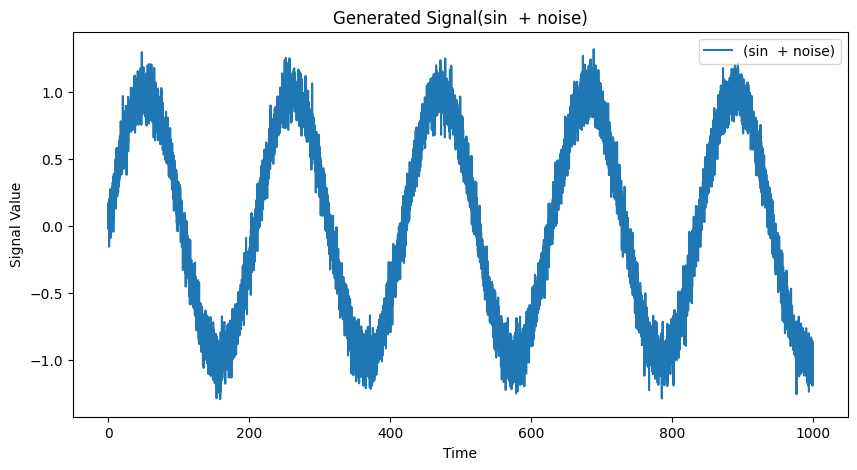

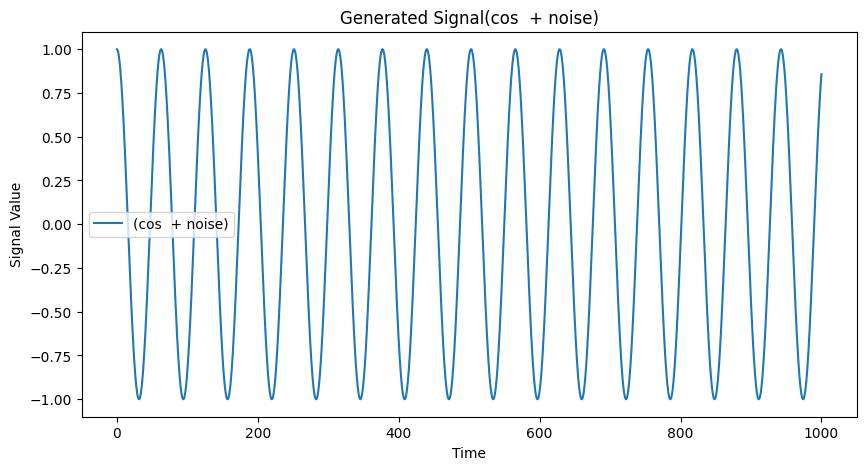

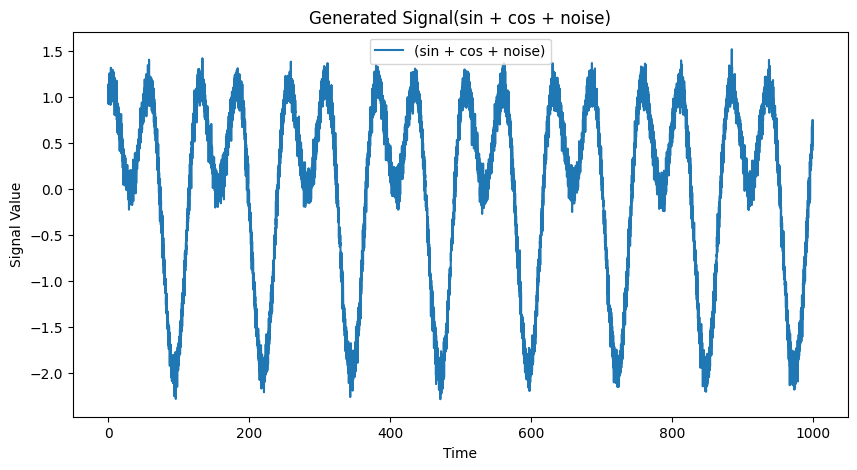

In [3]:
visualize_generated_signal(time, sin_signal,'(sin  + noise)')
visualize_generated_signal(time, cos_signal,'(cos  + noise)')
visualize_generated_signal(time, signal,'(sin + cos + noise)')

# NEW

In [4]:
sin_signal[:10]

array([ 0.04967142, -0.01082643,  0.07076882,  0.16130286, -0.01141563,
       -0.00841426,  0.17592031,  0.09774193, -0.02294974,  0.08125272])

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, RNN, LSTMCell
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_features = 1

def get_data_from_signal(signal):
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))
    train, valid, test = split_train_valid_test(signal_scaled)

    #generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

    train_generator = create_TimeseriesGenerator(train, n_input)
    valid_generator = create_TimeseriesGenerator(valid, n_input)
    test_generator = create_TimeseriesGenerator(test, n_input)

    return train_generator, valid_generator, test_generator, scaler

In [6]:
def split_train_valid_test(data):
    valid_set_size_percentage = 10
    test_set_size_percentage = 10

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    train = data[:train_set_size]
    valid = data[train_set_size:train_set_size+valid_set_size]
    test = data[train_set_size+valid_set_size:]
    return [train, valid, test]

In [7]:
def create_TimeseriesGenerator(data, n_input):
    return TimeseriesGenerator(data, data, length=n_input, batch_size=1)

In [28]:

def plot_visualization(history):
    # Visualize the training and validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def predict_sequence(model, dataset, scaler):
    predictions = model.predict(dataset)
    predictions = scaler.inverse_transform(predictions)

    return predictions

In [32]:
def calculate_metrics(original_signal, predictions, n_input):
    # Метрики
    test_actual = original_signal[n_input:len(predictions) + n_input]
    mse = mean_squared_error(test_actual, predictions)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse:.4f}')


def visualize_training(original_signal, train_predictions, valid_predictions, test_predictions=None, seq_len=3, n_input=4):
    plt.figure(figsize=(16, 10))

    # Візуалізація справжнього сигналу
    plt.plot(range(len(original_signal)), original_signal, color='blue', label='Actual Signal')

    # Довжина кожного набору
    train_len = len(train_predictions)
    valid_len = len(valid_predictions)
    test_len = len(test_predictions) if test_predictions is not None else 0

    # Візуалізація прогнозів зі зміщенням
    plt.plot(np.arange(n_input, n_input + train_len), train_predictions, color='red', label='Train Predictions')
    plt.plot(np.arange(n_input + train_len, n_input + train_len + valid_len), valid_predictions, color='orange', label='Validation Predictions')

    if test_predictions is not None:
        plt.plot(np.arange(n_input + train_len + valid_len, n_input + train_len + valid_len + test_len),
                 test_predictions, color='green', label='Test Predictions')

    plt.title('Signal Forecasting')
    plt.xlabel('Time Steps')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.grid()
    plt.show()


In [33]:
def train_model(model, train_generator, valid_generator, test_generator, scaler, signal, n_input):
    """
    Навчання моделі з розрахунком метрик та візуалізацією
    """
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(train_generator, epochs=3, batch_size=32, validation_data=(valid_generator), verbose=1)
    plot_visualization(history)
    # Прогнози
    train_predictions = predict_sequence(model, train_generator, scaler)
    valid_predictions = predict_sequence(model, valid_generator, scaler)
    test_predictions = predict_sequence(model, test_generator, scaler)

    # Візуалізація та метрики
    visualize_training(signal, train_predictions, valid_predictions, test_predictions, seq_len=n_input, n_input=n_input)
    calculate_metrics(signal, test_predictions, n_input)


In [12]:
def SimpleRNN(input_shape=(n_input, n_features)):
    model = Sequential()
    model.add(RNN(LSTMCell(50), return_sequences=True, input_shape=(n_input, n_features)))
    model.add(RNN(LSTMCell(50), return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_30 (RNN)                         │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_31 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7996/7996 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 2/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0014 - val_loss: 9.7623e-04
Epoch 3/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0013 - val_loss: 9.1159e-04


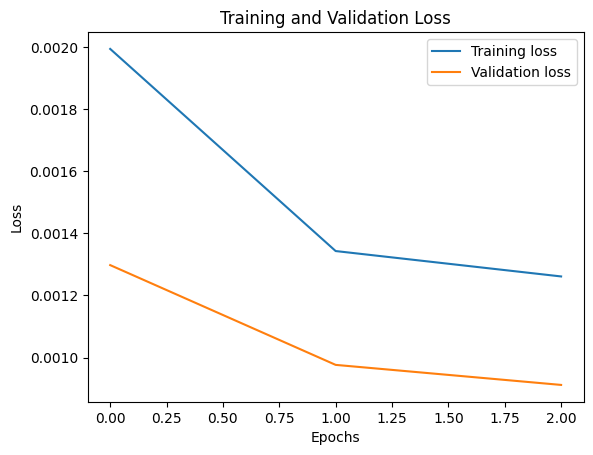

7996/7996 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 87/996 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


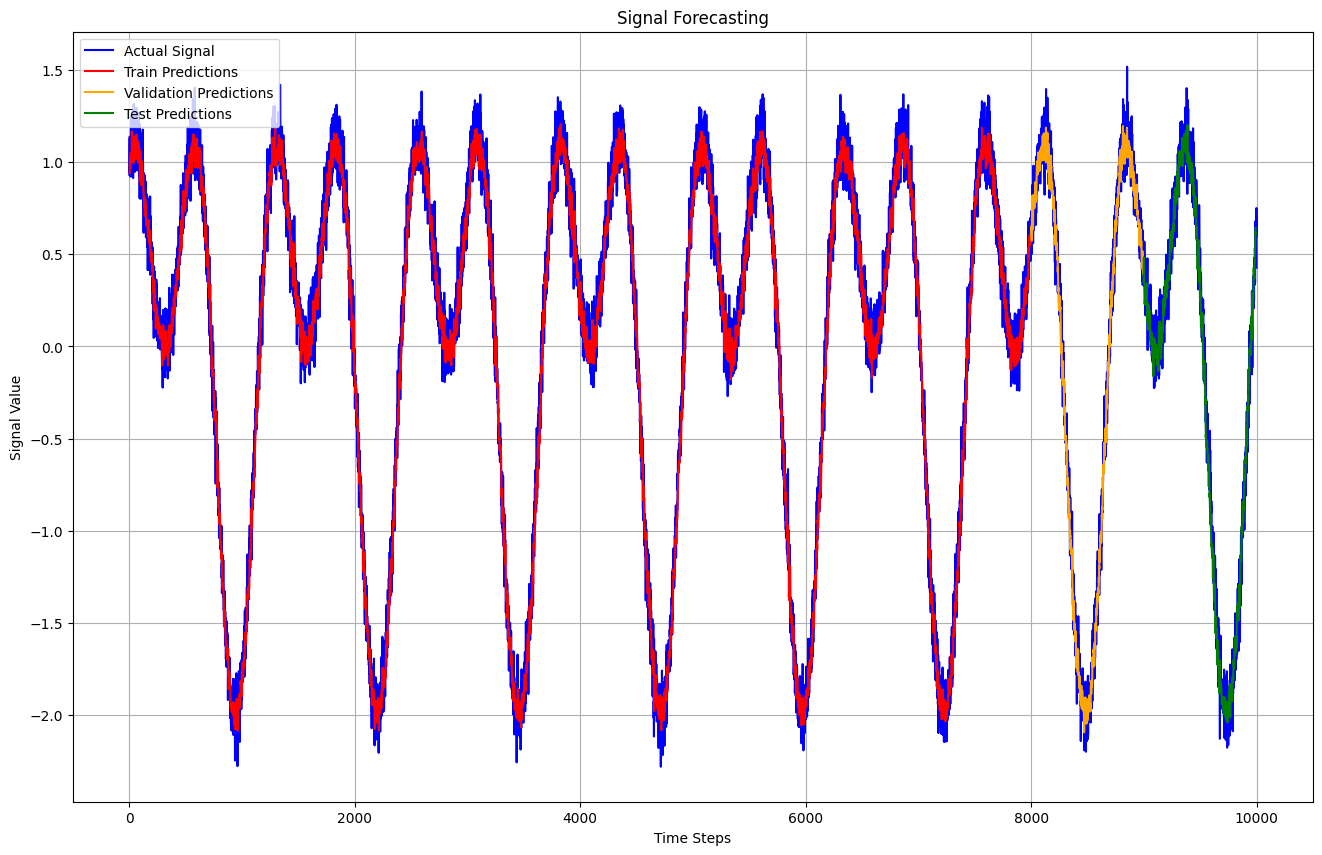

Root Mean Squared Error: 1.3187


In [34]:
n_input = 4
modelRNN2 = SimpleRNN((n_input, n_features))
SIGNAL = signal

train_generator, valid_generator, test_generator, scaler = get_data_from_signal(SIGNAL)
train_model(modelRNN2, train_generator, valid_generator, test_generator, scaler, SIGNAL, n_input)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_34 (RNN)                         │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_35 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7996/7996 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 2/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0023 - val_loss: 0.0020


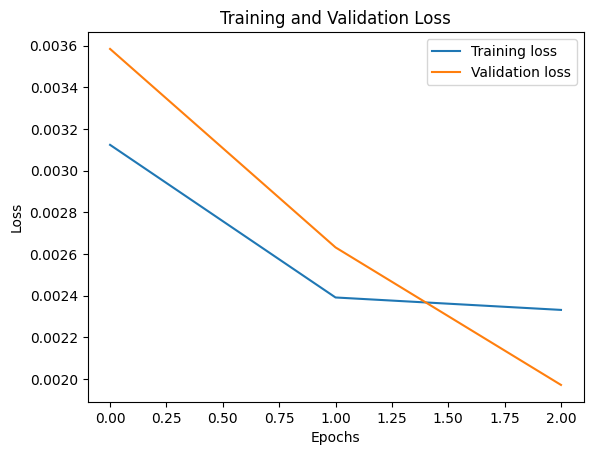

7996/7996 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 80/996 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


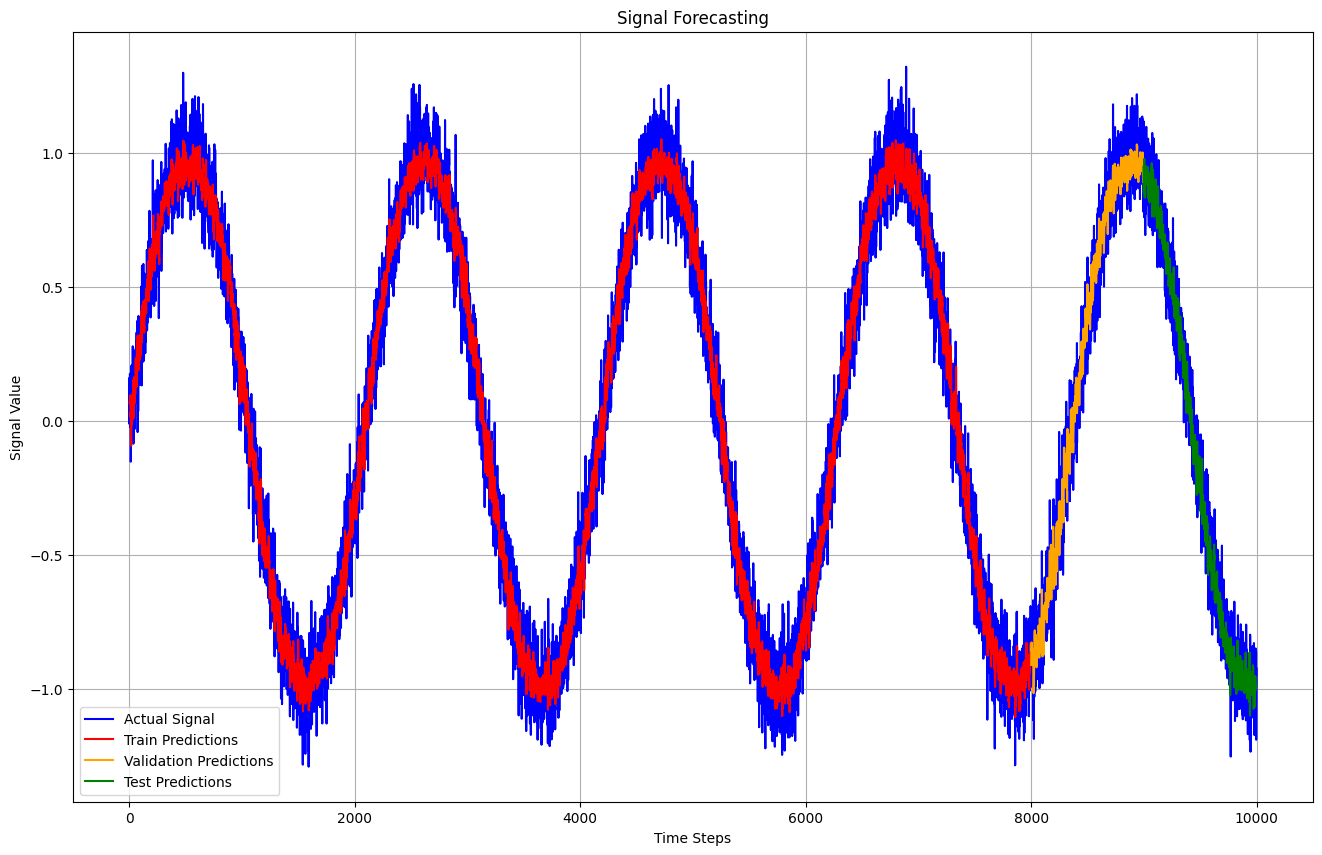

Root Mean Squared Error: 1.1505


In [36]:
n_input = 4
modelRNN = SimpleRNN((n_input, n_features))
SIGNAL = sin_signal

train_generator, valid_generator, test_generator, scaler = get_data_from_signal(SIGNAL)
train_model(modelRNN, train_generator, valid_generator, test_generator, scaler, SIGNAL, n_input)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_38 (RNN)                         │ (None, 3, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_39 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7997/7997 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0043 - val_loss: 1.3941e-04
Epoch 2/3
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 2.6368e-04 - val_loss: 6.3686e-05
Epoch 3/3
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.6547e-04 - val_loss: 8.2893e-05


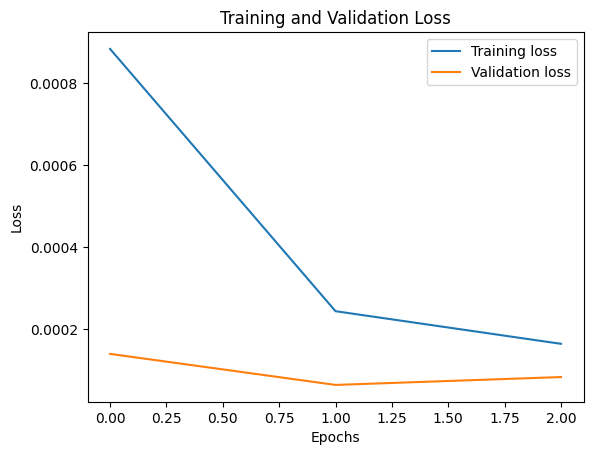

7997/7997 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
997/997 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 88/997 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


997/997 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


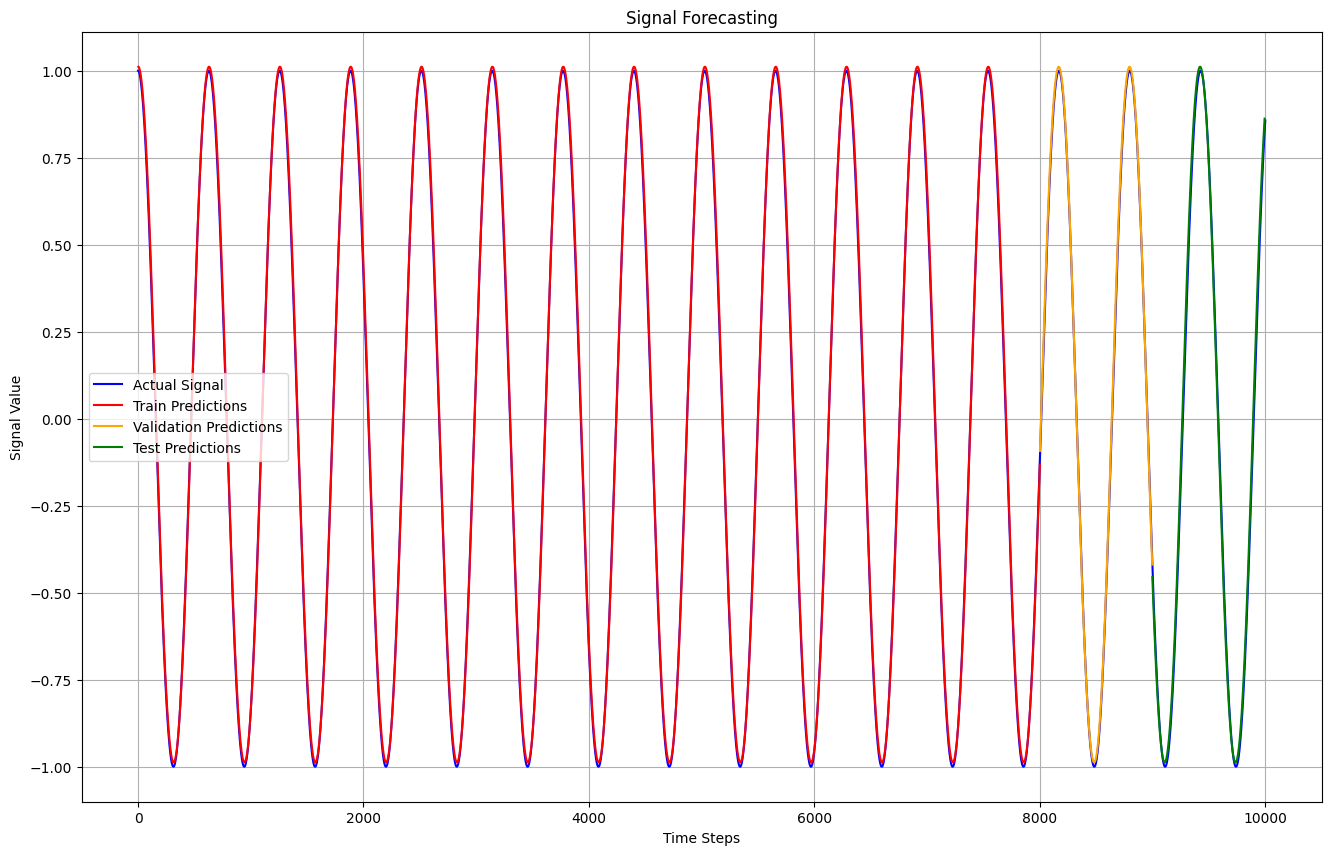

Root Mean Squared Error: 1.2246


In [38]:
n_input = 3
modelRNN3 = SimpleRNN((n_input, n_features))
SIGNAL = cos_signal

train_generator, valid_generator, test_generator, scaler = get_data_from_signal(SIGNAL)
train_model(modelRNN3, train_generator, valid_generator, test_generator, scaler, SIGNAL, n_input)


In [24]:
# Можливі значення n_input
n_input_values = [4, 8, 16, 32, 64, 120]

results = []  # Для збереження метрик

for n_input in n_input_values:
    print(f"Training with n_input={n_input}")

    # Генерація даних
    train_generator, valid_generator, test_generator, scaler = get_data_from_signal(signal)

    # Модель
    model = SimpleRNN((n_input, n_features))

    # Навчання
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=3, batch_size=32, validation_data=valid_generator, verbose=0)

    # Прогнози
    test_predictions = predict_sequence(model, test_generator, scaler)

    # Метрики
    test_actual = signal[n_input:len(test_predictions) + n_input]
    mse = mean_squared_error(test_actual, test_predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_actual - test_predictions))

    print(f"Metrics for n_input={n_input}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

    # Зберегти результати
    results.append({'n_input': n_input, 'MSE': mse, 'RMSE': rmse, 'MAE': mae})

# Знайти найкраще n_input
best_result = min(results, key=lambda x: x['MSE'])
print(f"Best n_input: {best_result['n_input']} with MSE={best_result['MSE']:.4f}")


Training with n_input=4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_14 (RNN)                         │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_15 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Metrics for n_input=4: MSE=1.6520, RMSE=1.2853, MAE=1.1247
Training with n_input=8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_16 (RNN)                         │ (None, 8, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_17 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Metrics for n_input=8: MSE=1.7749, RMSE=1.3322, MAE=1.1683
Training with n_input=16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_18 (RNN)                         │ (None, 16, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_19 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Metrics for n_input=16: MSE=1.6761, RMSE=1.2946, MAE=1.1353
Training with n_input=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_20 (RNN)                         │ (None, 32, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_21 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


968/968 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Metrics for n_input=32: MSE=1.7036, RMSE=1.3052, MAE=1.1297
Training with n_input=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_22 (RNN)                         │ (None, 64, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_23 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Metrics for n_input=64: MSE=1.8707, RMSE=1.3678, MAE=1.1841
Training with n_input=120


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_24 (RNN)                         │ (None, 120, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_25 (RNN)                         │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


880/880 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Metrics for n_input=120: MSE=1.8505, RMSE=1.3603, MAE=1.1753
Best n_input: 4 with MSE=1.6520


# bad

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn (RNN)                            │ (None, 200, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_1 (RNN)                          │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7800/7800 ━━━━━━━━━━━━━━━━━━━━ 170s 21ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 2/3
7800/7800 ━━━━━━━━━━━━━━━━━━━━ 198s 21ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/3
7800/7800 ━━━━━━━━━━━━━━━━━━━━ 202s 21ms/step - loss: 0.0021 - val_loss: 0.0034
7800/7800 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
 26/800 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


ValueError: Found input variables with inconsistent numbers of samples: [603, 800]

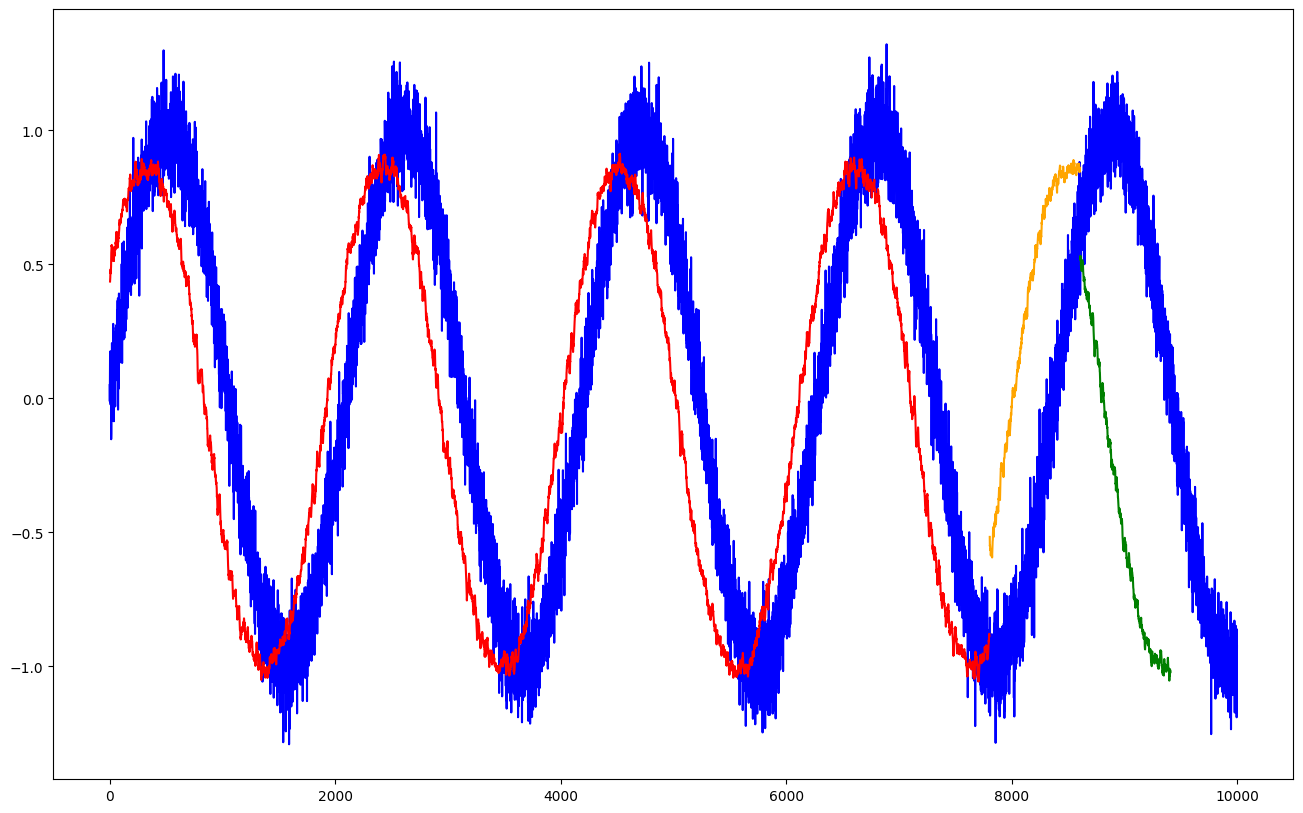

In [14]:
modelRNN = SimpleRNN()
SIGNAL = sin_signal

train_model(modelRNN, *get_data_from_signal(SIGNAL))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_4 (RNN)                          │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_5 (RNN)                          │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7996/7996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 2/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0024 - val_loss: 0.0026
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 66/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: Found input variables with inconsistent numbers of samples: [995, 996]

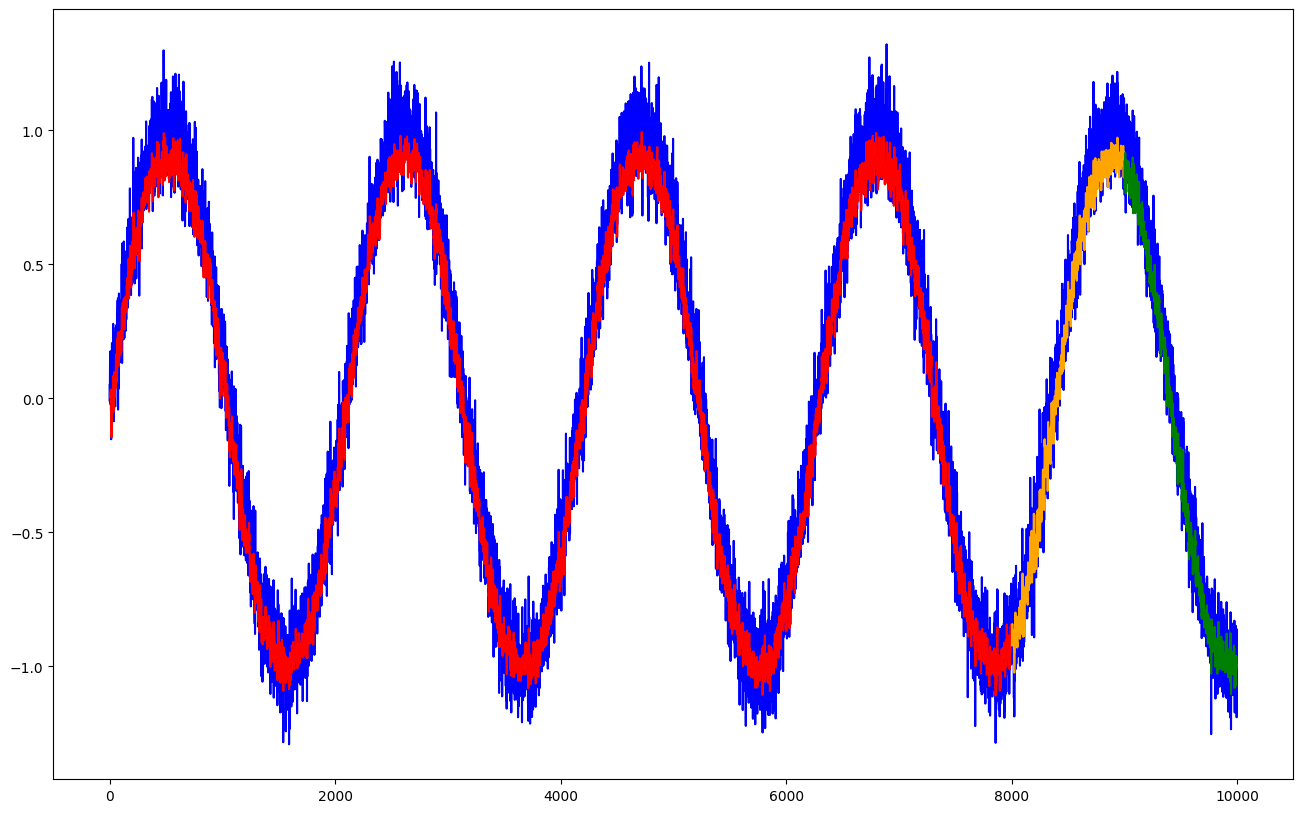

In [16]:
n_input = 4
modelRNN2 = SimpleRNN((n_input, n_features))
SIGNAL = sin_signal

train_model(modelRNN2, *get_data_from_signal(SIGNAL))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_6 (RNN)                          │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_7 (RNN)                          │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7996/7996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0033 - val_loss: 2.1426e-04
Epoch 2/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.5790e-04 - val_loss: 1.6065e-04
Epoch 3/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.6077e-04 - val_loss: 8.2778e-06
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 67/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: Found input variables with inconsistent numbers of samples: [995, 996]

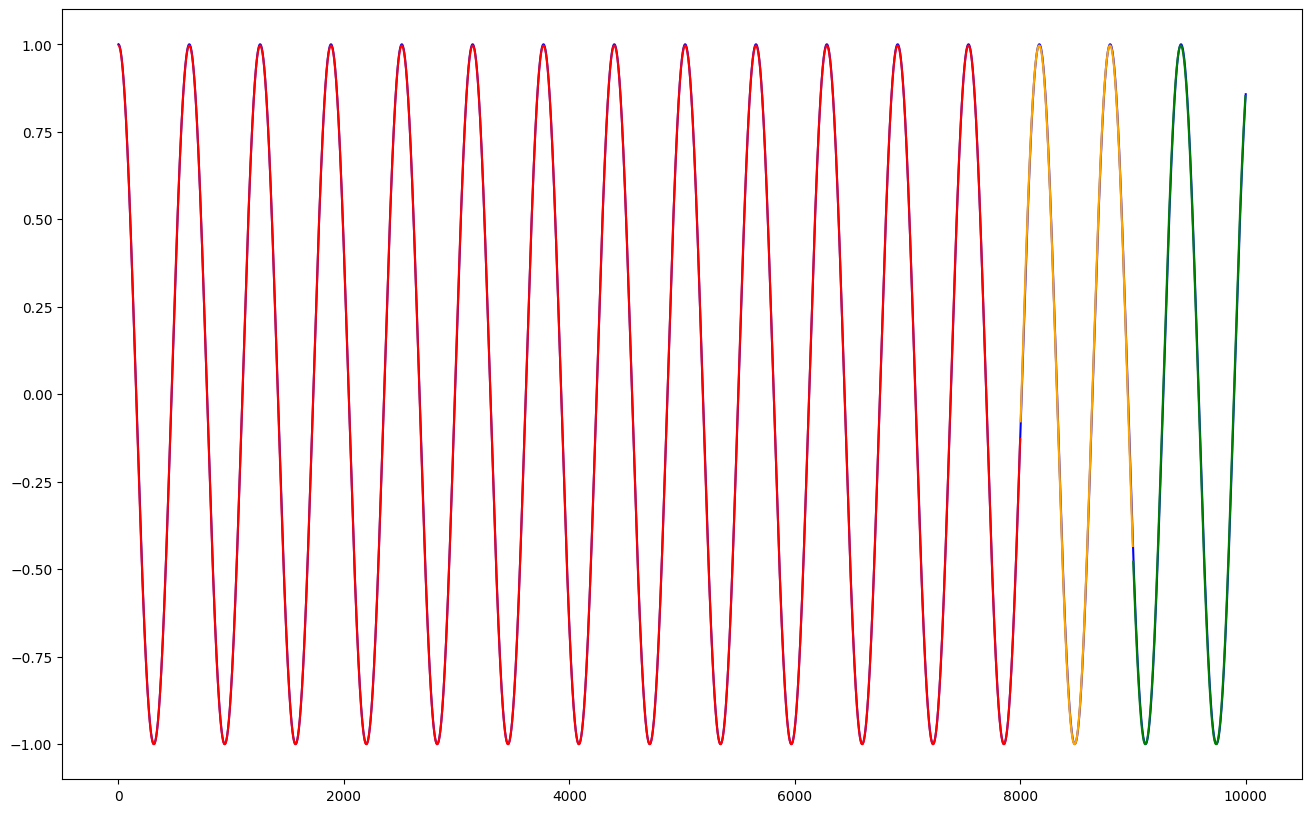

In [17]:
n_input = 4
modelRNN2 = SimpleRNN((n_input, n_features))
SIGNAL = cos_signal

train_model(modelRNN2, *get_data_from_signal(SIGNAL))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_8 (RNN)                          │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_9 (RNN)                          │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7996/7996 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 2/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0014 - val_loss: 9.6413e-04
Epoch 3/3
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0013 - val_loss: 0.0010
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 63/996 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: Found input variables with inconsistent numbers of samples: [995, 996]

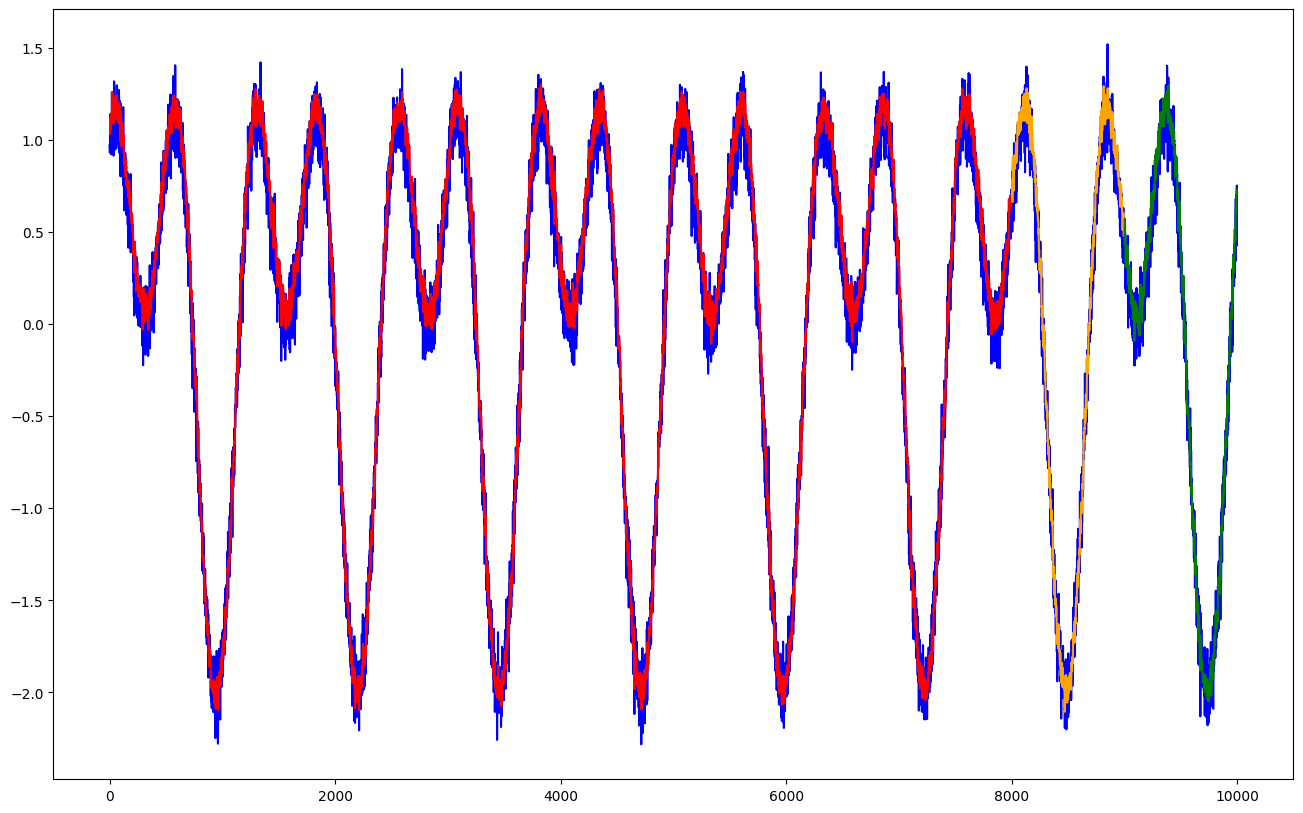

In [18]:
n_input = 4
modelRNN2 = SimpleRNN((n_input, n_features))
SIGNAL = signal

train_model(modelRNN2, *get_data_from_signal(SIGNAL))

# bad

In [ ]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest
## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft], color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]), y_valid_pred[:,ft], color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft], color='green', label='test prediction')
plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  36/7997 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.2535

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7997/7997 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 2/5
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 3/5
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/5
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/5
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 0.0023 - val_loss: 0.0021
9997/9997 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step


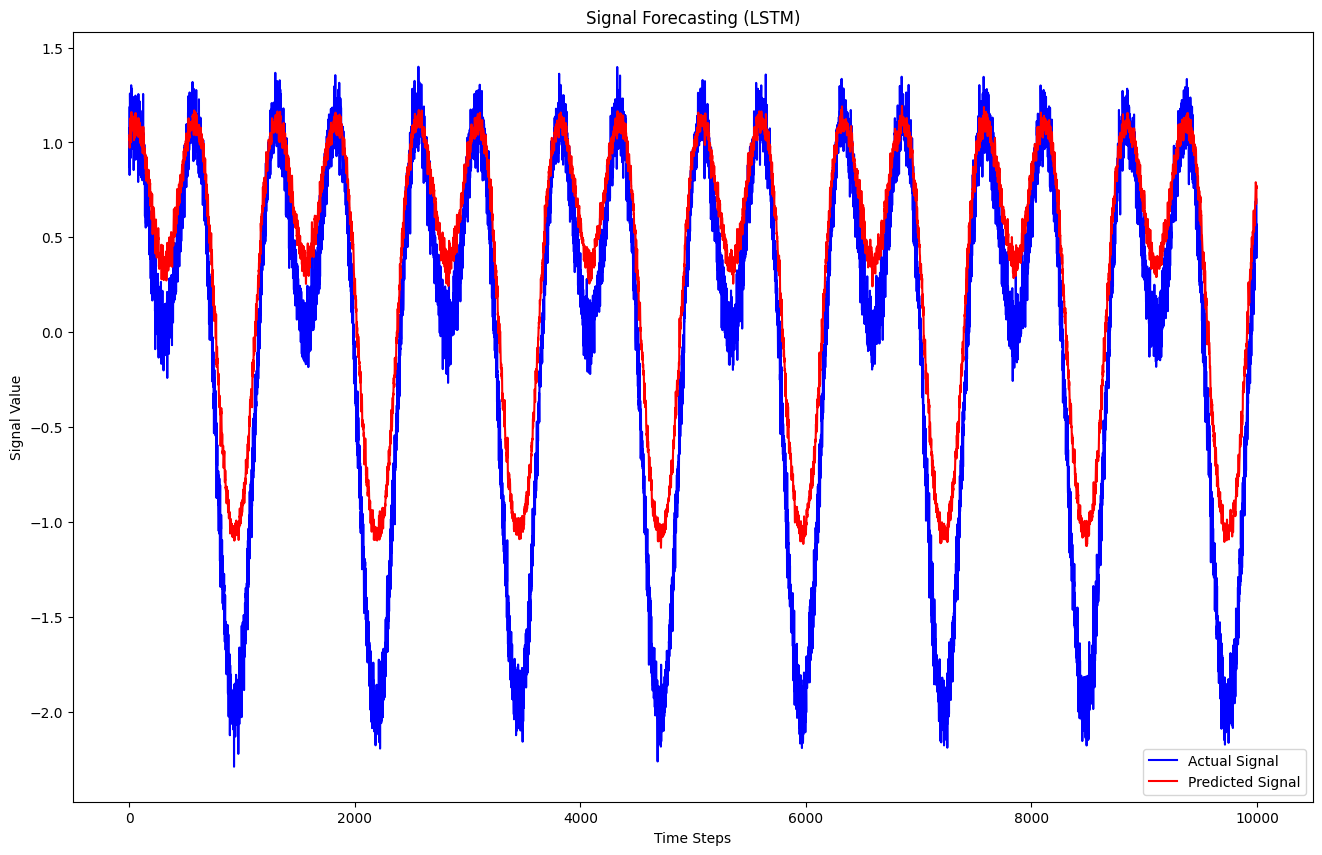

Root Mean Squared Error: 0.4616


In [ ]:
train_model(*get_data_from_signal(sin_signal))

In [ ]:

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')


Given the Array: 
[0.90132057 0.90090135 0.86914441]
Predict this y: 
 [[0.91153599]]


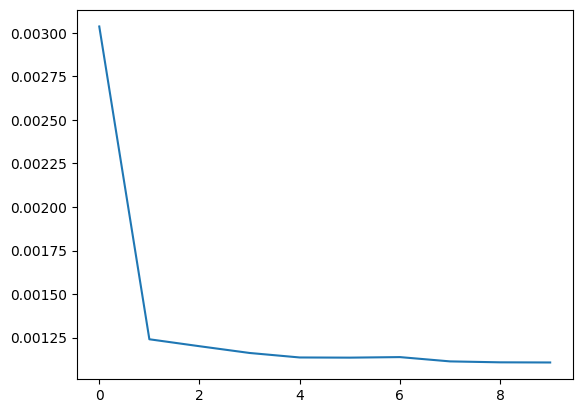

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
def visualize_training(history,model,dataset,scaler, scaled_train_Y):
    #plot_training_history(history)
    # Predicting on test data
    predictions = model.predict(dataset)
    predictions = scaler.inverse_transform(predictions)  # Inverse scaling for predictions

    # Inverse scaling of actual values
    #y_test_inv = scaler.inverse_transform(scaled_train_Y[n_input:])

    # Plot the results
    plt.figure(figsize=(16, 10))
    plt.plot(range(len(signal[n_input:])), signal[n_input:], color='blue', label='Actual Signal')
    plt.plot(range(len(predictions)), predictions, color='red', label='Predicted Signal')
    plt.title('Signal Forecasting (LSTM)')
    plt.xlabel('Time Steps')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()

    # Calculate metrics
    mse = mean_squared_error(y_test_inv, predictions)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse:.4f}')


9997/9997 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step


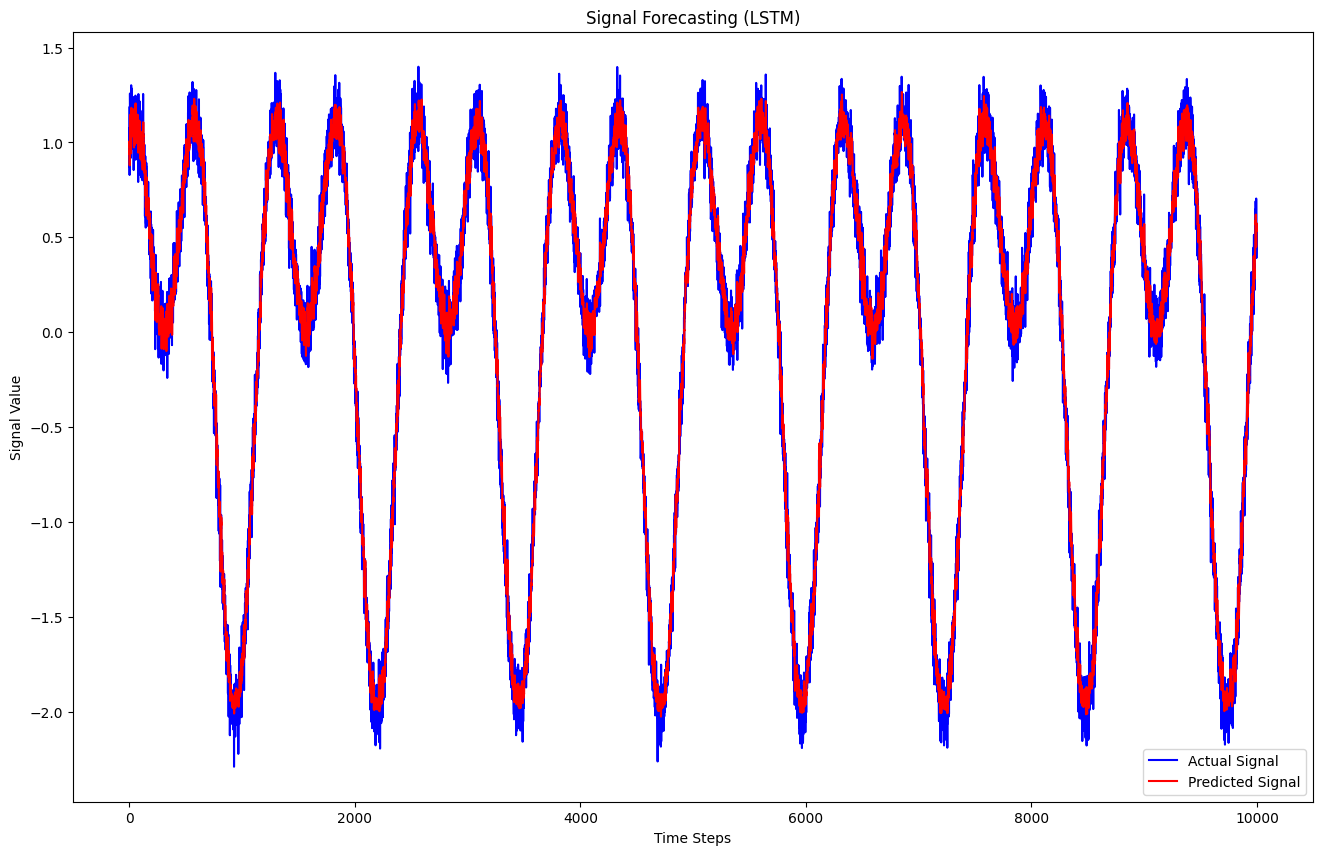

Root Mean Squared Error: 0.1153


In [ ]:
visualize_training(model.history,model,generator,scaler, scaled_train)